In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col,isnan,when,count,countDistinct,lit
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler,VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier,LinearSVC,NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator


In [5]:
#SparkSession and Dataframe creation:
spark=SparkSession.builder.appName("classification1").getOrCreate()
"""
a)SparkSession.builder: This creates a SparkSession.Builder object, which is used to configure the 
Spark session.
b).appName("classification1"): This sets the application name to "classification1". 
The application name is a human-readable name for your Spark application, which appears in the Spark UI and logs.
c).getOrCreate(): This method tries to get an existing SparkSession or, if there is no existing one,
creates a new one. 

"""
#load the dataset 
myFile="breastcancer.csv"
df=spark.read.format("csv").option("header","true").option("inferSchema","true").load(myFile)

"""
spark.read.format("csv"): This specifies that the data is in CSV format.
.option("header", "true"): This tells Spark to consider the first row of the CSV file as the header, i.e., column names. 
If set to false, Spark will assign auto-generated column names.
.option("inferSchema", "true"): This tells Spark to automatically infer the schema (data types) of the columns from the data.
If set to false, all columns will be read as strings.
.load(myFile): This loads the data from the specified file (myFile) into a DataFrame (df).
"""

24/05/06 09:14:15 WARN Utils: Your hostname, priyankas-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.29.100 instead (on interface en0)
24/05/06 09:14:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/06 09:14:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


'\nspark.read.format("csv"): This specifies that the data is in CSV format.\n.option("header", "true"): This tells Spark to consider the first row of the CSV file as the header, i.e., column names. \nIf set to false, Spark will assign auto-generated column names.\n.option("inferSchema", "true"): This tells Spark to automatically infer the schema (data types) of the columns from the data.\nIf set to false, all columns will be read as strings.\n.load(myFile): This loads the data from the specified file (myFile) into a DataFrame (df).\n'

24/05/06 09:14:32 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


# EXPLORATIVE ANALYSIS

In [6]:
#Show some rows and columns of the dataframe to understand it better:
df.select(df.columns[:10]).show(8)

#Dataframe shape
print("Dataframe's shape: (%s,%d)" %(df.count(), len(df.columns)))


+--------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+
|      id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|
+--------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+
|  842302|        M|      17.99|       10.38|         122.8|   1001.0|         0.1184|          0.2776|        0.3001|             0.1471|
|  842517|        M|      20.57|       17.77|         132.9|   1326.0|        0.08474|         0.07864|        0.0869|            0.07017|
|84300903|        M|      19.69|       21.25|         130.0|   1203.0|         0.1096|          0.1599|        0.1974|             0.1279|
|84348301|        M|      11.42|       20.38|         77.58|    386.1|         0.1425|          0.2839|        0.2414|             0.1052|
|84358402|        M|      2

In [7]:
#Count the NULL values in every column:
nullValues = df.select([count(when(col(c).isNull(),c)).alias(c) for c in df.columns]).show(truncate=False,vertical=True)
#33th column has ONLY NULL values --> you have to delete it:
df2=df.drop(F.col("_c32"))
#df2.show(1)
print("                 Column ""c_32"" deleted -->    Shape of the new dataframe : (%s,%d) " %(df2.count(),len(df2.columns)))
print("")
#Count the number of 'M' and 'B' diagnosis:
print("Number of M  and  B diagnosis:")
df2.groupBy("diagnosis").count().show()

24/05/06 09:14:44 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0----------------------
 id                      | 0   
 diagnosis               | 0   
 radius_mean             | 0   
 texture_mean            | 0   
 perimeter_mean          | 0   
 area_mean               | 0   
 smoothness_mean         | 0   
 compactness_mean        | 0   
 concavity_mean          | 0   
 concave points_mean     | 0   
 symmetry_mean           | 0   
 fractal_dimension_mean  | 0   
 radius_se               | 0   
 texture_se              | 0   
 perimeter_se            | 0   
 area_se                 | 0   
 smoothness_se           | 0   
 compactness_se          | 0   
 concavity_se            | 0   
 concave points_se       | 0   
 symmetry_se             | 0   
 fractal_dimension_se    | 0   
 radius_worst            | 0   
 texture_worst           | 0   
 perimeter_worst         | 0   
 area_worst              | 0   
 smoothness_worst        | 0   
 compactness_worst       | 0   
 concavity_worst         | 0   
 concave points_worst    | 0   
 symmetr

/Users/priyankanagpal/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


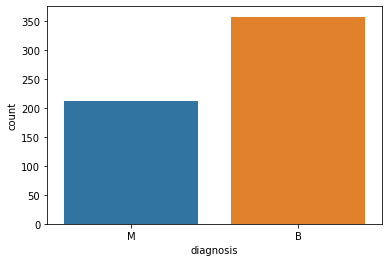

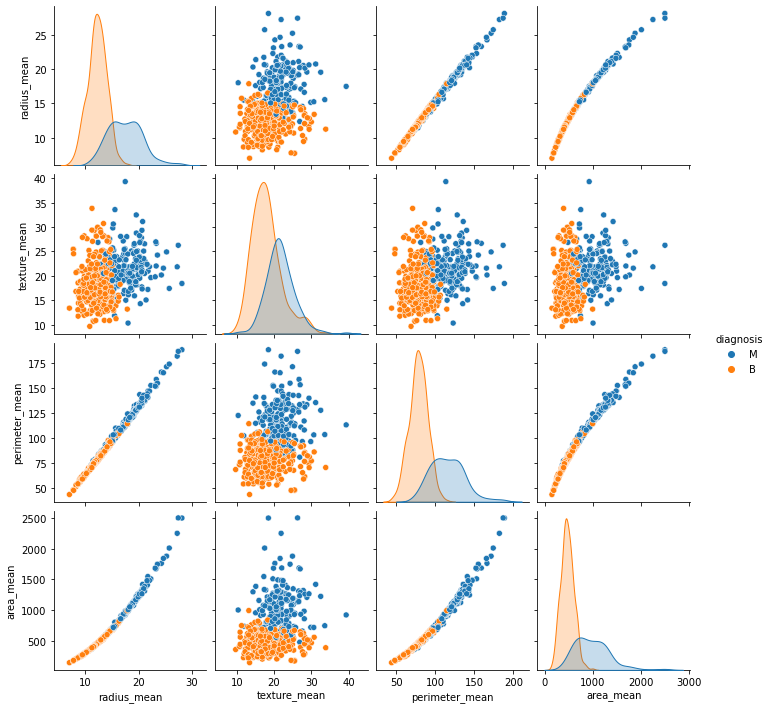

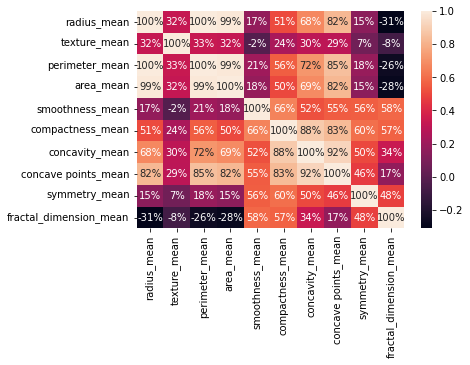

In [8]:
#Creation of different graphs to understand better the dataframe:
#This line converts the Spark DataFrame df2 to a Pandas DataFrame 
df3=df2.toPandas()
plot1=sns.countplot(df3['diagnosis'],label='count')
plt.show()

#Pairplot graph creation:
plot2=sns.pairplot(df3.iloc[:,1:6], hue='diagnosis')
plt.show()

#Show the correlation between columns:
df3.corr()

#Show only some of the previous computed correlation values (only for the first 11 columns):
plot3=sns.heatmap(df3.iloc[:,1:12].corr(),annot=True,fmt='.0%')
plt.show()

# PIPELINE

In [8]:
#Creation of a function with all the operations to compute always at the beginning of every pipeline
#for every classification method used:

def start():
    global indexer,vector,stdScaler,train,test

    indexer=StringIndexer(inputCol="diagnosis", outputCol="categoryIndex")

    vector=VectorAssembler(inputCols=['radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean','concave points_mean','symmetry_mean','fractal_dimension_mean','radius_se','texture_se','perimeter_se','area_se','smoothness_se','compactness_se','concavity_se','concave points_se','symmetry_se','fractal_dimension_se','radius_worst','texture_worst','perimeter_worst','area_worst','smoothness_worst','compactness_worst','concavity_worst','concave points_worst','symmetry_worst','fractal_dimension_worst'], outputCol="features")

    stdScaler=StandardScaler(inputCol="features",outputCol="scaled")

    train,test =df2.randomSplit([0.7,0.3])


start()


#Creation of different functions to call recursively for every classification algorithm to use:
def LogRegr():
    global pipeline
    lr=LogisticRegression(labelCol="categoryIndex",featuresCol="features",maxIter=10)
    pipeline=Pipeline(stages=[indexer,vector,stdScaler,lr])


def DecisTree():
    global pipeline
    tree=DecisionTreeClassifier(labelCol="categoryIndex",featuresCol="features")
    pipeline=Pipeline(stages=[indexer,vector,stdScaler,tree])


def RandForest():
    global pipeline
    forest=RandomForestClassifier(featuresCol="features",labelCol="categoryIndex")
    pipeline=Pipeline(stages=[indexer,vector,stdScaler,forest])

def SVCLinear():
    global pipeline
    svc_lin=LinearSVC(labelCol="categoryIndex",featuresCol="features",maxIter=5)
    pipeline=Pipeline(stages=[indexer,vector,stdScaler,svc_lin])

def NaiveBay():
    global pipeline
    naive=NaiveBayes(labelCol="categoryIndex",featuresCol="features",modelType="gaussian")
    pipeline=Pipeline(stages=[indexer,vector,stdScaler,naive])

In [10]:
#We create a List containing all the functions created above, to be able to call them one after the other,
#executing the various classification algorithms in sequence one after the other
functionList=[LogRegr,DecisTree,RandForest,SVCLinear,NaiveBay]
algorithmNames=["LOGISTIC REGRESSION","DECISION TREE","RANDOM FOREST","LINEAR SVC","NAIVE BAYES"]

for i in range(len(functionList)):
    functionList[i]()
    algorithmNames[i]
    
    #This line fits a pipeline model (pipeline) on the training data (train). 
    #The model is fitted using the algorithm specified by the current function in the loop.
    model=pipeline.fit(train)

    # This line makes predictions on the test data (test) using the model obtained from the previous step. 
    #It transforms the test data using the fitted model, resulting in a DataFrame containing predictions.
    prediction=model.transform(test)

    # We create two lists, (one for the true values and one for the predictions) just for a better display on the terminal
    selection=prediction.select(F.col("categoryIndex").cast("int"),F.col("prediction").cast("int"))
    trueVal_list=list(selection.select("categoryIndex").toPandas()["categoryIndex"])
    predictVal_list=list(selection.select("prediction").toPandas()["prediction"])

    print("//////////////////////////////////////////////---------------------------------------//////////////////////////////////////////////////////")
    print("                                                   -------- %s --------                                 " %algorithmNames[i])
    print("-------------------------------------------------------------------------------------------------------------------------------------------")
    print("TRUE VALUES : ")
    print(trueVal_list)
    print("-------------------------------------------------------------------------------------------------------------------------------------------")
    print("PREDICTIONS : ")
    print(predictVal_list)
    print("-------------------------------------------------------------------------------------------------------------------------------------------")
    print("")


24/05/06 09:15:33 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/06 09:15:33 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


//////////////////////////////////////////////---------------------------------------//////////////////////////////////////////////////////
                                                   -------- LOGISTIC REGRESSION --------                                 
-------------------------------------------------------------------------------------------------------------------------------------------
TRUE VALUES : 
[0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1]
------------------

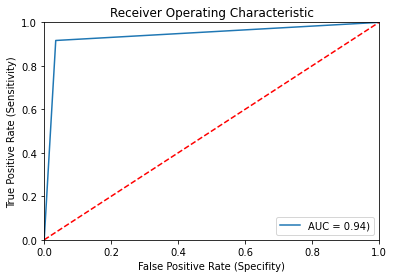

In [11]:
#The sklearn library is used to produce the CONFUSION MATRIX and other metrics:
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc
evaluator=MulticlassClassificationEvaluator(labelCol="categoryIndex",predictionCol="prediction")
y_true=prediction.select(["categoryIndex"]).collect()
y_predicted=prediction.select(["prediction"]).collect()

#Creation of the ROC-AUC CURVE graph
#Calculation of the values fpr, tpr, thresholds and roc_auc useful for the construction of the curve:
fpr, tpr, thresholds = roc_curve(y_true, y_predicted)
roc_auc = auc(fpr, tpr)

# ROC curve plot:
plt.plot(fpr, tpr, label='AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (Specifity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [14]:
    #Other calculated metrics (accuracy, precision, f1 score and recall):
    print(classification_report(y_true,y_predicted))
    accuracy=evaluator.evaluate(prediction,{evaluator.metricName:"accuracy"})
    precision=evaluator.evaluate(prediction,{evaluator.metricName:"precisionByLabel"})
    f1_score=evaluator.evaluate(prediction,{evaluator.metricName:"f1"})
    recall=evaluator.evaluate(prediction,{evaluator.metricName:"recallByLabel"})
    print("Accuracy = %g " % accuracy)
    print("Test error = %g " % (1.0-accuracy))
    print("Precision = %g " % precision )
    print("F1 score = %g " % f1_score)
    print("Recall = %g " % recall)
    print("-------------------------------------------------------------------------------------------------------------------------------------------")
    print("")
    print("")
    print("")




              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95       105
         1.0       0.96      0.85      0.90        61

    accuracy                           0.93       166
   macro avg       0.94      0.92      0.93       166
weighted avg       0.94      0.93      0.93       166

Accuracy = 0.933735 
Test error = 0.0662651 
Precision = 0.919643 
F1 score = 0.932787 
Recall = 0.980952 
-------------------------------------------------------------------------------------------------------------------------------------------





In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt

# Define evaluation metrics
def evaluate_model(prediction):
    evaluator = MulticlassClassificationEvaluator(labelCol="categoryIndex", predictionCol="prediction")
    accuracy = evaluator.evaluate(prediction, {evaluator.metricName: "accuracy"})
    precision = evaluator.evaluate(prediction, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(prediction, {evaluator.metricName: "weightedRecall"})
    f1_score = evaluator.evaluate(prediction, {evaluator.metricName: "f1"})
    return accuracy, precision, recall, f1_score

# Define a dictionary to store evaluation metrics for each algorithm
metrics = {}

# Loop through each algorithm
for i, func in enumerate(functionList):
    func()  # Fit the model
    model = pipeline.fit(train)
    prediction = model.transform(test)
    
    y_true = prediction.select(["categoryIndex"]).collect()
    y_predicted = prediction.select(["prediction"]).collect()
    
    # Evaluate the model
    accuracy, precision, recall, f1_score = evaluate_model(prediction)
    metrics[algorithmNames[i]] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1_score}
    

# Print the evaluation metrics for each algorithm
for algorithm, metric in metrics.items():
    print("Algorithm:", algorithm)
    print("Accuracy:", metric['Accuracy'])
    print("Precision:", metric['Precision'])
    print("Recall:", metric['Recall'])
    print("F1-Score:", metric['F1-Score'])
    print("\n")


Algorithm: LOGISTIC REGRESSION
Accuracy: 0.9680851063829787
Precision: 0.9681417752820565
Recall: 0.9680851063829787
F1-Score: 0.9679967420452886


Algorithm: DECISION TREE
Accuracy: 0.9468085106382979
Precision: 0.9481982882738762
Recall: 0.9468085106382979
F1-Score: 0.9470607225366464


Algorithm: RANDOM FOREST
Accuracy: 0.9414893617021277
Precision: 0.9416952846805975
Recall: 0.9414893617021276
F1-Score: 0.9415644761206023


Algorithm: LINEAR SVC
Accuracy: 0.9787234042553191
Precision: 0.9787234042553192
Recall: 0.9787234042553192
F1-Score: 0.9787234042553192


Algorithm: NAIVE BAYES
Accuracy: 0.9468085106382979
Precision: 0.946741538303024
Recall: 0.9468085106382979
F1-Score: 0.9466612367421477




In [15]:
spark.stop()